# Project 4: Good-Fast-Cheap
*Muhammad Haseeb Anjum, Graham Haun, Melissa Marshall, Deval Mehta, Damar Shipp*

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# Set random seed for reproducability
np.random.seed(42)

## Cleaning the Data

In [2]:
# Read in the data and check the first few rows
train = pd.read_csv('./data/large_train_sample.csv')
test = pd.read_csv('./data/test_data.csv')
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [3]:
# Check dtypes and for nulls
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  wage            32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [4]:
for column in train.columns:
    print(column)
    print('')
    print(train[column].unique())
    print('')
    print('---')

age

[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]

---
workclass

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

---
fnlwgt

[ 77516  83311 215646 ...  34066  84661 257302]

---
education

[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

---
education-num

[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]

---
marital-status

[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

---
occupation

[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-mo

In [5]:
print(test['native-country'].unique())

[' United-States' ' ?' ' Peru' ' Guatemala' ' Mexico'
 ' Dominican-Republic' ' Ireland' ' Germany' ' Philippines' ' Thailand'
 ' Haiti' ' El-Salvador' ' Puerto-Rico' ' Vietnam' ' South' ' Columbia'
 ' Japan' ' India' ' Cambodia' ' Poland' ' Laos' ' England' ' Cuba'
 ' Taiwan' ' Italy' ' Canada' ' Portugal' ' China' ' Nicaragua'
 ' Honduras' ' Iran' ' Scotland' ' Jamaica' ' Ecuador' ' Yugoslavia'
 ' Hungary' ' Hong' ' Greece' ' Trinadad&Tobago'
 ' Outlying-US(Guam-USVI-etc)' ' France']


In [6]:
# Get unique countries in the test dataframe
test_countries = set(test['native-country'].unique())
# Filter the training data to only include countries present in the test dataframe
train = train[train['native-country'].isin(test_countries)]

In [7]:
# Isolate categorical variables
cat_vars = ['workclass','education','marital-status','occupation','relationship','sex','native-country']

for column in cat_vars:
    train[column] = train[column].str.strip()
    test[column] = test[column].str.strip()

train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [8]:
# Drop rows with missing data
train = train.replace(' ?', np.nan)
train = train.dropna() 
test = test.replace(' ?', np.nan)
test = test.dropna()

In [9]:
# Map wage
wage_map = {' <=50K': 0, ' >50K': 1}

train['wage'] = train['wage'].map(wage_map)

train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0


In [10]:
train['wage'].value_counts()

wage
0    24719
1     7841
Name: count, dtype: int64

## Baseline Model: Full-Feature Random Forest with Hyperparameter Tuning

In [11]:
# Dummify categorical data
baseline_train = pd.get_dummies(train, 
                       columns = cat_vars,
                       dtype = int,
                       drop_first = True)
baseline_test = pd.get_dummies(test, 
                      columns=cat_vars,
                      dtype=int,
                      drop_first = True)

baseline_train.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Assign X and y
X = baseline_train.drop(columns = 'wage')
y = baseline_train['wage']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [13]:
# Instantiate a baseline model
rf = RandomForestClassifier()

# Define parameter grid for RS
param_grid = {
    'n_estimators': np.arange(50,250),  # Number of trees in the forest
    'max_depth': np.arange(1,31),  # Maximum depth of the tree
    'min_samples_split': [2,3,4]  # Minimum number of samples to split a node
}

# Instantiate RSCV
rs_1 = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid,
    n_iter = 50,
    cv=5,
    n_jobs = 12
)

# Fit the model
rs_1.fit(X_train, y_train)
rs_1.predict(X_test)

C:\Users\deval\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


array([0, 0, 0, ..., 0, 0, 0])

In [14]:
print('Best Parameters:', rs_1.best_params_)
print('Best Cross-Validation Score:', rs_1.best_score_)
print('Training Accuracy:', rs_1.score(X_train,y_train))
print('Test Accuracy:', rs_1.score(X_test,y_test))

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 19}
Best Cross-Validation Score: 0.8604013104013104
Training Accuracy: 0.913963963963964
Test Accuracy: 0.8670761670761671


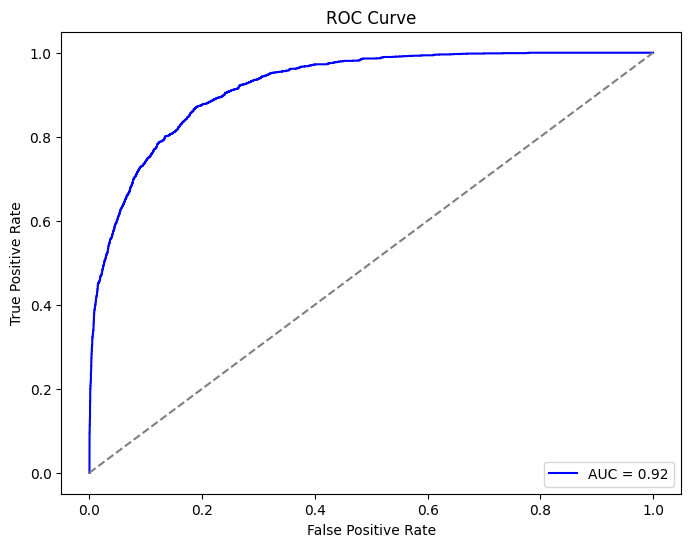

In [15]:
# Predict probabilities
y_pred_prob = rs_1.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Data Exploration and Further Cleaning

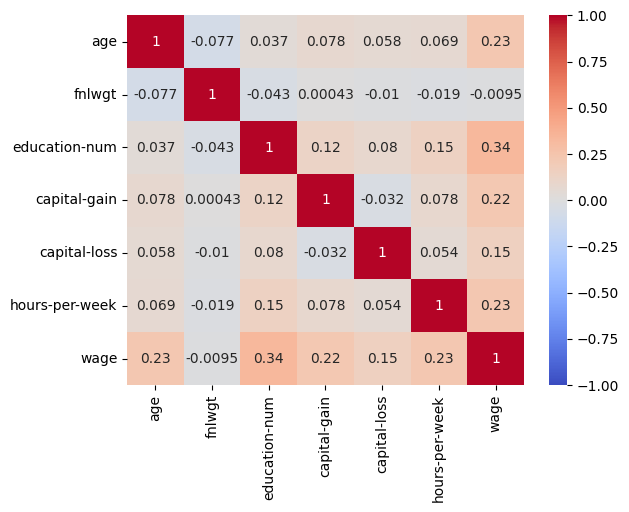

In [16]:
# Correlation between numeric variables
sns.heatmap(train.corr(numeric_only = True),
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm',
            annot = True);

Conclusion: Drop `fnlwgt`, since it has a near 0 correlation coefficient with `wage`

In [17]:
train['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [18]:
# Binarize marital status
married_map = {'Never-married': 0,
               'Married-civ-spouse': 1,
               'Divorced': 2,
               'Married-spouse-absent': 1,
               'Separated': 2,
               'Married-AF-spouse': 1,
               'Widowed': 2}

train['has-married'] = train['marital-status'].map(married_map)
test['has-married'] = test['marital-status'].map(married_map)
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage,has-married
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0,2
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0,1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0,1


In [19]:
train['relationship'].unique()

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [20]:
# Binarize relationship status
relation_map = {'Not-in-family': 0,
                'Husband': 1,
                'Wife': 1,
                'Own-child': 1,
                'Unmarried': 0,
                'Other-relative': 1}

train['has-family'] = train['relationship'].map(relation_map)
test['has-family'] = test['relationship'].map(relation_map)
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage,has-married,has-family
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,0,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0,1,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0,2,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0,1,1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0,1,1


In [21]:
consistency_check = train.groupby('education')['education-num'].nunique()
print(consistency_check)

education
10th            1
11th            1
12th            1
1st-4th         1
5th-6th         1
7th-8th         1
9th             1
Assoc-acdm      1
Assoc-voc       1
Bachelors       1
Doctorate       1
HS-grad         1
Masters         1
Preschool       1
Prof-school     1
Some-college    1
Name: education-num, dtype: int64


Columns to include: age, education-num, capital-gain, capital-loss, hours-per-week, has-married, has-family, occupation, native-country

## Second model: Grouped features with less dummificaiton

In [22]:
# Dummify categorical data
rel_train = pd.get_dummies(train, 
                       columns = ['workclass', 'occupation', 'native-country', 'sex'],
                       dtype = int,
                       drop_first = True)
rel_test = pd.get_dummies(test, 
                      columns=['workclass', 'occupation', 'native-country', 'sex'],
                      dtype=int,
                      drop_first = True)

rel_train.head()

,age,fnlwgt,education,education-num,marital-status,relationship,capital-gain,capital-loss,hours-per-week,wage,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Male
0,39,77516,Bachelors,13,Never-married,Not-in-family,2174,0,40,0,...,0,0,0,0,0,0,1,0,0,1
1,50,83311,Bachelors,13,Married-civ-spouse,Husband,0,0,13,0,...,0,0,0,0,0,0,1,0,0,1
2,38,215646,HS-grad,9,Divorced,Not-in-family,0,0,40,0,...,0,0,0,0,0,0,1,0,0,1
3,53,234721,11th,7,Married-civ-spouse,Husband,0,0,40,0,...,0,0,0,0,0,0,1,0,0,1
4,28,338409,Bachelors,13,Married-civ-spouse,Wife,0,0,40,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Assign X and y
X = rel_train.drop(columns = ['marital-status', 'education', 'relationship', 'fnlwgt', 'wage'])
y = rel_train['wage']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [24]:
# Instantiate a baseline model
rf = RandomForestClassifier()

# Define parameter grid for RS
param_grid = {
    'n_estimators': np.arange(50,250),  # Number of trees in the forest
    'max_depth': np.arange(1,31),  # Maximum depth of the tree
    'min_samples_split': [2,3,4]  # Minimum number of samples to split a node
}

# Instantiate RSCV
rs_2 = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid,
    n_iter = 50,
    cv=5,
    n_jobs = 12
)

# Fit the model
rs_2.fit(X_train, y_train)
rs_2.predict(X_test)

array([0, 1, 0, ..., 0, 0, 0])

In [25]:
print('Best Parameters:', rs_2.best_params_)
print('Best Cross-Validation Score:', rs_2.best_score_)
print('Training Accuracy:', rs_2.score(X_train,y_train))
print('Test Accuracy:', rs_2.score(X_test,y_test))

Best Parameters: {'n_estimators': 196, 'min_samples_split': 4, 'max_depth': 20}
Best Cross-Validation Score: 0.8629811629811629
Training Accuracy: 0.905036855036855
Test Accuracy: 0.8663390663390663


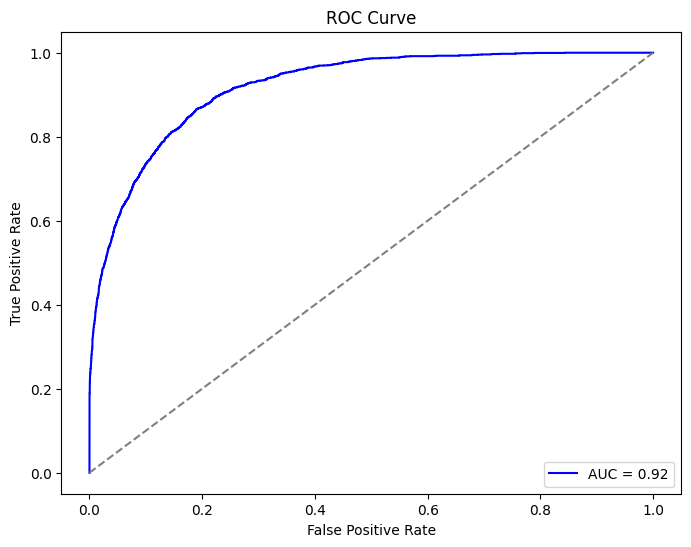

In [26]:
# Predict probabilities
y_pred_prob = rs_2.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Engineer Net Capital Feature and Binarize Education

In [27]:
train['net-capital'] = train['capital-gain'] - train['capital-loss']
test['net-capital'] = test['capital-gain'] - test['capital-loss']

train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage,has-married,has-family,net-capital
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,0,0,0,2174
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0,1,1,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0,2,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0,1,1,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0,1,1,0


In [28]:
train['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [29]:
educ_map = {'Bachelors': 1,
            'HS-grad': 0,
            '11th': 0,
            'Masters': 1,
            '9th': 0,
            'Some-college': 0,
            'Assoc-acdm': 0,
            'Assoc-voc': 0,
            '7th-8th': 0,
            'Doctorate': 1,
            'Prof-school': 1,
            '5th-6th': 0,
            '10th': 0,
            '1st-4th': 0,
            'Preschool': 0,
            '12th': 0}

train['has-4yr-comp'] = train['education'].map(educ_map)
test['has-4yr-comp'] = test['education'].map(educ_map)

In [30]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage,has-married,has-family,net-capital,has-4yr-comp
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,0,0,0,2174,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0,1,1,0,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0,2,0,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0,1,1,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0,1,1,0,1


In [31]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,has-married,has-family,net-capital,has-4yr-comp
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Male,0,0,40,United-States,0,1,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,50,United-States,1,1,0,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,Male,0,0,40,United-States,1,1,0,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Male,7688,0,40,United-States,1,1,7688,0
4,18,?,103497,Some-college,10,Never-married,?,Own-child,Female,0,0,30,United-States,0,1,0,0


## Third Model: Incorporating `net-capital` and `has-4yr-comp`, dropping `workclass`, `education-num`

In [32]:
# Dummify categorical data
group_train = pd.get_dummies(train, 
                       columns = ['occupation', 'native-country', 'sex'],
                       dtype = int,
                       drop_first = True)
group_test = pd.get_dummies(test, 
                      columns=['occupation', 'native-country', 'sex'],
                      dtype=int,
                      drop_first = True)

group_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,relationship,capital-gain,capital-loss,hours-per-week,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Male
0,39,State-gov,77516,Bachelors,13,Never-married,Not-in-family,2174,0,40,...,0,0,0,0,0,0,1,0,0,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Husband,0,0,13,...,0,0,0,0,0,0,1,0,0,1
2,38,Private,215646,HS-grad,9,Divorced,Not-in-family,0,0,40,...,0,0,0,0,0,0,1,0,0,1
3,53,Private,234721,11th,7,Married-civ-spouse,Husband,0,0,40,...,0,0,0,0,0,0,1,0,0,1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Wife,0,0,40,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Assign X and y
X = group_train.drop(columns = ['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'wage'])
y = group_train['wage']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [34]:
# Instantiate a baseline model
rf = RandomForestClassifier()

# Define parameter grid for RS
param_grid = {
    'n_estimators': np.arange(50,250),  # Number of trees in the forest
    'max_depth': np.arange(1,31),  # Maximum depth of the tree
    'min_samples_split': [2,3,4]  # Minimum number of samples to split a node
}

# Instantiate RSCV
rs_3 = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid,
    n_iter = 50,
    cv=5,
    n_jobs = 12
)

# Fit the model
rs_3.fit(X_train, y_train)
rs_3.predict(X_test)

array([1, 0, 0, ..., 0, 0, 1])

In [35]:
print('Best Parameters:', rs_3.best_params_)
print('Best Cross-Validation Score:', rs_3.best_score_)
print('Training Accuracy:', rs_3.score(X_train,y_train))
print('Test Accuracy:', rs_3.score(X_test,y_test))

Best Parameters: {'n_estimators': 194, 'min_samples_split': 3, 'max_depth': 19}
Best Cross-Validation Score: 0.8597051597051596
Training Accuracy: 0.8896805896805897
Test Accuracy: 0.860933660933661


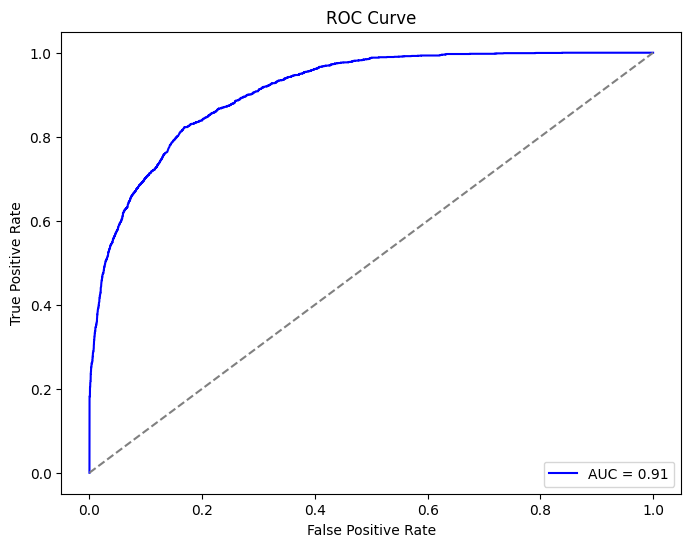

In [36]:
# Predict probabilities
y_pred_prob = rs_3.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Fourth Model: Continue to remove `workclass`, keep `education-num`

In [37]:
# Assign X and y
X = group_train.drop(columns = ['workclass', 'fnlwgt', 'education', 'has-4yr-comp', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'wage'])
y = group_train['wage']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [38]:
# Instantiate a baseline model
rf = RandomForestClassifier()

# Define parameter grid for RS
param_grid = {
    'n_estimators': np.arange(50,250),  # Number of trees in the forest
    'max_depth': np.arange(1,31),  # Maximum depth of the tree
    'min_samples_split': [2,3,4]  # Minimum number of samples to split a node
}

# Instantiate RSCV
rs_4 = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid,
    n_iter = 50,
    cv=5,
    n_jobs = 12
)

# Fit the model
rs_4.fit(X_train, y_train)
rs_4.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
print('Best Parameters:', rs_4.best_params_)
print('Best Cross-Validation Score:', rs_4.best_score_)
print('Training Accuracy:', rs_4.score(X_train,y_train))
print('Test Accuracy:', rs_4.score(X_test,y_test))

Best Parameters: {'n_estimators': 195, 'min_samples_split': 3, 'max_depth': 15}
Best Cross-Validation Score: 0.8601965601965602
Training Accuracy: 0.8770270270270271
Test Accuracy: 0.8592137592137592


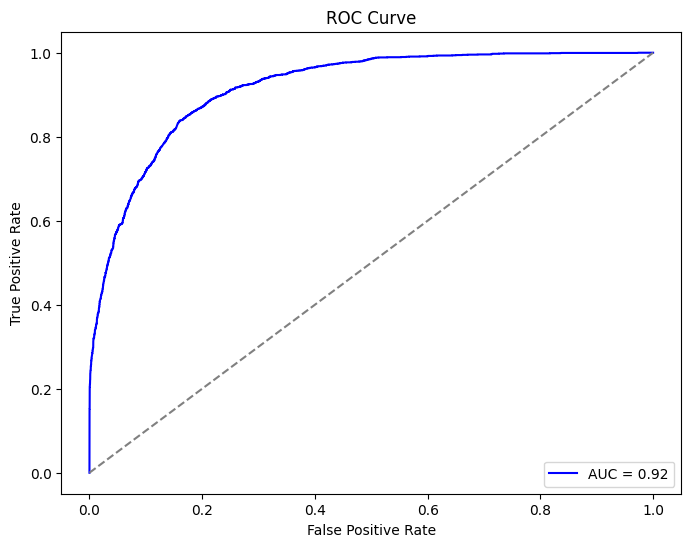

In [40]:
# Predict probabilities
y_pred_prob = rs_4.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Least Overfit Model: Model 4
Model 3 demonstrates a roughly 3% difference in accuracy between our training and testing sets. We'll predict on the provided test_data using model 4.

In [41]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,has-married,has-family,net-capital,has-4yr-comp
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Male,0,0,40,United-States,0,1,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,50,United-States,1,1,0,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,Male,0,0,40,United-States,1,1,0,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Male,7688,0,40,United-States,1,1,7688,0
4,18,?,103497,Some-college,10,Never-married,?,Own-child,Female,0,0,30,United-States,0,1,0,0


In [43]:
test = pd.get_dummies(test, 
                      columns=['occupation', 'native-country', 'sex'],
                      dtype=int,
                      drop_first = True)

KeyError: "None of [Index(['occupation', 'native-country', 'sex'], dtype='object')] are in the [columns]"

In [46]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,relationship,capital-gain,capital-loss,hours-per-week,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Male
0,25,Private,226802,11th,7,Never-married,Own-child,0,0,40,...,0,0,0,0,0,0,1,0,0,1
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Husband,0,0,50,...,0,0,0,0,0,0,1,0,0,1
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Husband,0,0,40,...,0,0,0,0,0,0,1,0,0,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Husband,7688,0,40,...,0,0,0,0,0,0,1,0,0,1
4,18,?,103497,Some-college,10,Never-married,Own-child,0,0,30,...,0,0,0,0,0,0,1,0,0,0


In [44]:
test_preds = rs_3.predict(test.drop(columns = ['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']))
test_preds[:5]

array([0, 0, 0, 1, 0])

In [48]:
test_probs = rs_4.predict_proba(test.drop(columns = ['workclass', 'fnlwgt', 'education', 'has-4yr-comp', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']))
test_probs[:5]

array([[0.993 , 0.007 ],
       [0.7662, 0.2338],
       [0.7282, 0.2718],
       [0.1227, 0.8773],
       [0.9953, 0.0047]])

In [54]:
single_probs = []
for probs in test_probs:
    single_probs.append(probs[1])

single_probs[:5]

[0.007040186138974405,
 0.23382503978008606,
 0.27180375033549414,
 0.8773333243509674,
 0.004688395784331834]

In [55]:
probs_df = pd.DataFrame(single_probs, columns = ['wage'])

probs_df.head()

,wage
0,0.007040
1,0.233825
2,0.271804
3,0.877333
4,0.004688


In [57]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,relationship,capital-gain,capital-loss,hours-per-week,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Male
0,25,Private,226802,11th,7,Never-married,Own-child,0,0,40,...,0,0,0,0,0,0,1,0,0,1
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Husband,0,0,50,...,0,0,0,0,0,0,1,0,0,1
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Husband,0,0,40,...,0,0,0,0,0,0,1,0,0,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Husband,7688,0,40,...,0,0,0,0,0,0,1,0,0,1
4,18,?,103497,Some-college,10,Never-married,Own-child,0,0,30,...,0,0,0,0,0,0,1,0,0,0


In [59]:
probs_df.to_csv('./fast_wage.csv', index = False)